#### We would run a feature selection technique based on ANOVA  tests and select only the top 10% most important features. Note: feature selection technique will be built in to a pipeline

In [26]:
import pandas as panda
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler,RobustScaler,label_binarize

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,\
    RepeatedStratifiedKFold,learning_curve

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest,f_classif,chi2

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, \
        classification_report,confusion_matrix,average_precision_score
from sklearn.linear_model import Perceptron, LogisticRegression,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plot
from itertools import cycle
import numpy as np 
from scipy import interp
import seaborn as sns
import itertools, time, datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from numpy import bincount, linspace, mean, std, arange, squeeze

import warnings

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
np.random.seed(123)

In [3]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

In [5]:
class CodeTimer:
    
    """
        Utility custom contextual class for calculating the time 
        taken for a certain code block to execute
    
    """
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))





def calculate_roc_and_prec_metrics(y, y_probabilities, number_of_classes):
    
    false_positive_rate_across_class    = dict()
    true_positive_rate_across_class     = dict()
    recall_across_class                 = dict()
    precision_across_class              = dict()
    roc_auc_across_class                = dict()
    average_precision_across_class      = dict()


    for i in range(number_of_classes):

        false_positive_rate_across_class[i], \
                true_positive_rate_across_class[i], _ = roc_curve(y[:, i], y_probabilities[:, i])

        precision_across_class[i], recall_across_class[i], _ = precision_recall_curve(y[:, i],
                                                        y_probabilities[:, i])

        average_precision_across_class[i] = average_precision_score(y[:, i], y_probabilities[:, i])

        roc_auc_across_class[i] = auc(false_positive_rate_across_class[i], true_positive_rate_across_class[i])

        # Compute micro-average ROC curve and ROC area

        false_positive_rate_across_class["micro"], \
                true_positive_rate_across_class["micro"], _ = roc_curve(y.ravel(), y_probabilities.ravel())

        roc_auc_across_class["micro"] = auc(false_positive_rate_across_class["micro"], \
                            true_positive_rate_across_class["micro"])


        precision_across_class["micro"], recall_across_class["micro"], _ = \
                    precision_recall_curve(y.ravel(), y_probabilities.ravel())

        average_precision_across_class["micro"] = average_precision_score(y, y_probabilities,
                                                            average="micro")

    response  = dict() 
    response['false_positive_rate_across_class']    = false_positive_rate_across_class
    response['true_positive_rate_across_class']     = true_positive_rate_across_class
    response['recall_across_class']                 = recall_across_class
    response['precision_across_class']              = precision_across_class
    response['roc_auc_across_class']                = roc_auc_across_class
    response['average_precision_across_class']      = average_precision_across_class

    return response


def plot_roc_auc_curve(false_positive_rate_across_class, \
            true_positive_rate_across_class, roc_auc_across_class, n_classes):
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([false_positive_rate_across_class[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(n_classes):
        mean_tpr += interp(all_fpr, false_positive_rate_across_class[i], true_positive_rate_across_class[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    false_positive_rate_across_class["macro"] = all_fpr
    true_positive_rate_across_class["macro"] = mean_tpr
    roc_auc_across_class["macro"] = auc(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"])

    # Plot all ROC curves
    plot.figure(figsize = (15,5))
    plot.plot(false_positive_rate_across_class["micro"], true_positive_rate_across_class["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plot.plot(false_positive_rate_across_class["macro"], true_positive_rate_across_class["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc_across_class["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plot.plot(false_positive_rate_across_class[i], true_positive_rate_across_class[i], color=color, lw=4,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(i, roc_auc_across_class[i]))

    plot.plot([0, 1], [0, 1], 'k--', lw=4)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.title('Some extension of Receiver operating characteristic to multi-class')
    plot.legend(loc="lower right")
    plot.show()




def plot_precision_recall_curve(recall_across_class, \
            precision_across_class, average_precision_across_class, n_classes):

    line_width = 4
    from itertools import cycle
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

    plot.figure(figsize=(15, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plot.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plot.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    lines.append(l)
    labels.append('iso-f1 curves')
    l, = plot.plot(recall_across_class["micro"], precision_across_class["micro"], color='gold', lw=line_width)
    lines.append(l)
    labels.append('micro-average Precision-recall (area = {0:0.2f})'
                ''.format(average_precision_across_class["micro"]))

    for i, color in zip(range(n_classes), colors):
        l, = plot.plot(recall_across_class[i], precision_across_class[i], color=color, lw=line_width)
        lines.append(l)
        labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                    ''.format(i, average_precision_across_class[i]))

    fig = plot.gcf()
    fig.subplots_adjust(bottom=0.25)
    plot.xlim([0.0, 1.0])
    plot.ylim([0.0, 1.05])
    plot.xlabel('Recall')
    plot.ylabel('Precision')
    plot.title('Extension of Precision-Recall curve to multi-class')
#     plot.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))
    plot.legend(lines, labels, loc='best', prop=dict(size=14))
    plot.show()

    

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()
    
    
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)

    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("F1 score %s" %f1_score(y_test,y_prediction, average ='weighted'))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
#         _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(range(_y_test.shape[1])))
        _matrix = confusion_matrix(y_true = _y_test ,y_pred = y_prediction, labels = list(set(_y_test)))
        classes = list(set(_y_test))
        plot_confusion_matrix(_matrix, classes)
        
    with predict_proba_timer:

        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            print('inside decision function')
            y_probability = gridsearch.predict_proba(x_test)
            number_of_classes = len(np.unique(y_train))
            y_test_bin = label_binarize(y_test, classes = np.unique(y_train))
            response = calculate_roc_and_prec_metrics(y_test_bin, y_probability, number_of_classes = number_of_classes)

            roc_params = {

                'false_positive_rate_across_class': response.get('false_positive_rate_across_class'),
                'true_positive_rate_across_class': response.get('true_positive_rate_across_class'),
                'roc_auc_across_class': response.get('roc_auc_across_class'),
                'n_classes': number_of_classes
            }

            precision_recall_params  = {

                'precision_across_class': response.get('precision_across_class'),
                'average_precision_across_class': response.get('average_precision_across_class'),
                'recall_across_class': response.get('recall_across_class'),
                'n_classes': number_of_classes
            }

            plot_roc_auc_curve(**roc_params)
            plot_precision_recall_curve(**precision_recall_params)
            response['roc_auc_micro'] = response.get('roc_auc_across_class',{}).get("micro")
            response['roc_auc_macro'] = response.get('roc_auc_across_class',{}).get("macro")
            
            
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_micro'] = 0
            response['roc_auc_macro'] = 0
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
#     response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction, average ='weighted')
    response['f1_score_micro']  = f1_score(y_test, y_prediction, average ='micro')
    response['f1_score_macro']  = f1_score(y_test, y_prediction, average ='macro')
    response['best_estimator'] = search.best_estimator_
    response['confusion_matrix'] = _matrix
    
    return response


In [6]:

## we will add more classifiers in round2
classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    DecisionTreeClassifier(),
    RandomForestClassifier(random_state = 1),
    KNeighborsClassifier(metric = 'minkowski'),
    RidgeClassifier(random_state = 123), 
    SVC(kernel='rbf',class_weight='balanced',probability=True)
]


classifier_names = [
            'perceptron',
            'logisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'ridge',
            'svc'
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [5,10,30], 'perceptron__eta0': [.1]},
            {'logisticregression__C':[100,300, 500]},
            {'decisiontreeclassifier__max_depth':[6,8,10],'decisiontreeclassifier__criterion':['gini','entropy']},
            {'randomforestclassifier__n_estimators':[6,8,12],'randomforestclassifier__criterion': ['gini',]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,10]},
            {'ridge__alpha':[1,1.2,0.9],'ridge__max_iter':[100,300,500]},
            {'svc__C':[1,1.2,0.5], 'svc__max_iter':[100,200]}
    
]


In [7]:

def execute( _x_train,
             _y_train,
             _x_test,
             _y_test, 
            classifiers, 
            classifier_names, 
            classifier_param_grid,
            cv  = 10 , 
            score = 'accuracy',
            scaler = StandardScaler()
           ):
    
    '''
    This method will run your data sets against the model specified 
    Models will be fed through a pipeline where the first step would be to
    execute a scaling operation.
    
    Method will also call additional lower level methods in order to plot
    precision curve, roc curve, learning curve and will also prepare a confusion matrix
    
    :returns: dict containing execution metrics such as time taken, accuracy scores
    :returntype: dict
    
    '''

    timer = CodeTimer(name='overalltime')
    model_metrics = {}

    with timer:
        for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

            pipeline = Pipeline([
                    ('scaler', scaler),
                    ('feature_select', SelectKBest(f_classif,10)),
                    (model_name, model)
            ])

            result = runGridSearchAndPredict(pipeline, 
                                             _x_train,
                                             _y_train,
                                             _x_test,
                                             _y_test, 
                                             model_param_grid ,
                                             cv = cv,
                                             score = 'f1_weighted')

            _y_prediction = result['_y_prediction']

#             cf = panda.crosstab(
#                 panda.Series(_y_test, name='Actual'),
#                 panda.Series(_y_prediction, name = 'Prediction'),
#                 margins = True
#             )

#             print(cf)

            model_metrics[model_name] = {}
            model_metrics[model_name]['confusion_matrix'] = result.get('confusion_matrix')
            model_metrics[model_name]['training_time'] = result.get('training_time')
            model_metrics[model_name]['testing_time'] = result.get('testing_time')
            model_metrics[model_name]['learning_curve_time'] = result.get('learning_curve_time')
            model_metrics[model_name]['f1_score'] = result.get('f1_score')
            model_metrics[model_name]['f1_score_macro'] = result.get('f1_score_macro')
            model_metrics[model_name]['f1_score_micro'] = result.get('f1_score_micro')
            model_metrics[model_name]['roc_auc_macro'] = result.get('roc_auc_macro')
            model_metrics[model_name]['roc_auc_micro'] = result.get('roc_auc_micro')

            model_metrics[model_name]['best_estimator'] = result.get('best_estimator')
#             model_metrics[model_name]['cf'] = cf


    print(timer.took)
    
    return model_metrics


In [8]:
train_data = panda.read_csv('data/train_2.csv')
test_data = panda.read_csv('data/test_2.csv')

In [9]:

columns_not_required = ['id','idhogar','target']
x = train_data[[i for i in train_data.columns.tolist() if i not in columns_not_required]]
y = train_data['target']


In [12]:
_x_train,_x_test,_y_train,_y_test = train_test_split(x,y, test_size = 0.3, stratify= y, random_state =12)


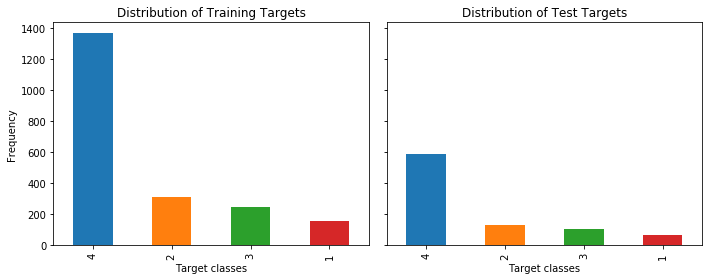

In [13]:


f, (ax1, ax2) = plot.subplots(1, 2, sharey=True, figsize=(10,4))
_y_train.value_counts().plot(kind='bar', label='Distribution of Training targets',ax=ax1)

ax1.set_xlabel('Target classes')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Training Targets')

_y_test.value_counts().plot(kind='bar', label='Distribution of Training targets', ax=ax2)

ax2.set_xlabel('Target classes')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Test Targets')
plot.tight_layout()
plot.show()

In [11]:
cv = StratifiedKFold(n_splits = 5, shuffle= True, random_state =123)
score= 'f1_weighted'
scaler = StandardScaler()

Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 30}
Grid Search Best score  0.5585149300470865
Code block 'training' took(HH:MM:SS): 0:00:00.671801
Code block 'testing' took(HH:MM:SS): 0:00:00.003999
F1 score 0.531712125015925
Classification report  
               precision    recall  f1-score   support

           1       0.22      0.07      0.11        67
           2       0.20      0.02      0.03       133
           3       0.00      0.00      0.00       106
           4       0.66      0.97      0.79       586

   micro avg       0.65      0.65      0.65       892
   macro avg       0.27      0.27      0.23       892
weighted avg       0.48      0.65      0.53       892



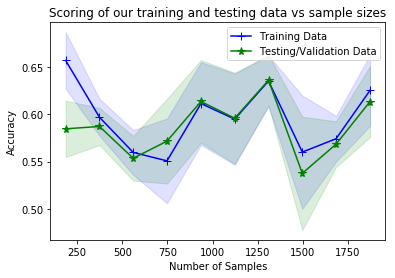

Confusion matrix, without normalization
[[  5   2   0  60]
 [  5   2   0 126]
 [  2   2   0 102]
 [ 11   4   0 571]]


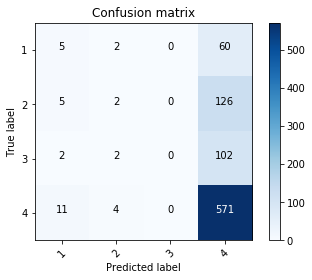

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.950984
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000015
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.5779157357249876
Code block 'training' took(HH:MM:SS): 0:00:00.768663
Code block 'testing' took(HH:MM:SS): 0:00:00.003387
F1 score 0.5747023379822702
Classification report  
               precision    recall  f1-score   support

           1       0.33      0.01      0.03        67
           2       0.30      0.23      0.26       133
           3       0.00      0.00      0.00       106
           4       0.71      0.95      0.81       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.34      0.30      0.27       892
weighted avg       0.54      0.66      0.57       892



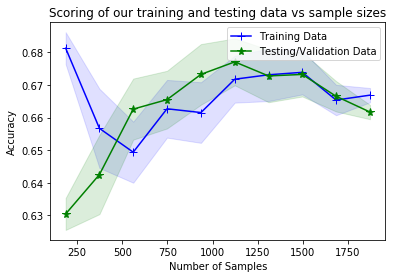

Confusion matrix, without normalization
[[  1  22   0  44]
 [  1  30   0 102]
 [  0  22   0  84]
 [  1  26   0 559]]


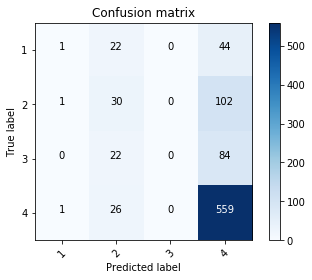

Code block 'learning_curve' took(HH:MM:SS): 0:00:03.135353
inside decision function


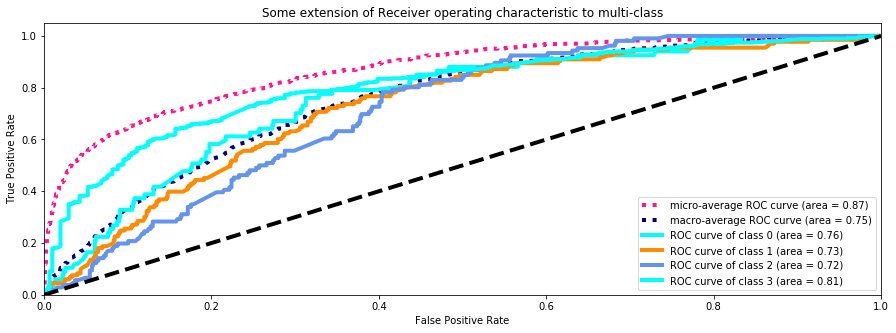

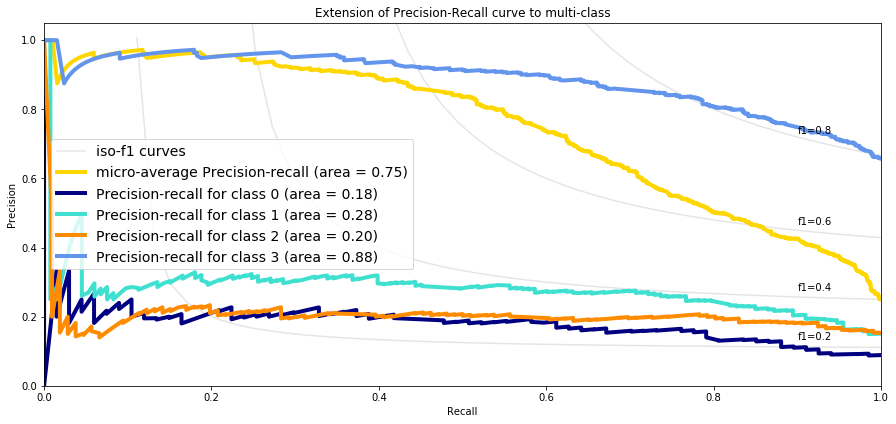

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.459618
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 6}
Grid Search Best score  0.5893820531402418
Code block 'training' took(HH:MM:SS): 0:00:01.003449
Code block 'testing' took(HH:MM:SS): 0:00:00.003162
F1 score 0.5840113273994109
Classification report  
               precision    recall  f1-score   support

           1       0.20      0.09      0.12        67
           2       0.30      0.24      0.27       133
           3       0.33      0.02      0.04       106
           4       0.72      0.92      0.81       586

   micro avg       0.65      0.65      0.65       892
   macro avg       0.39      0.32      0.31       892
weighted avg       0.57      0.65      0.58       892



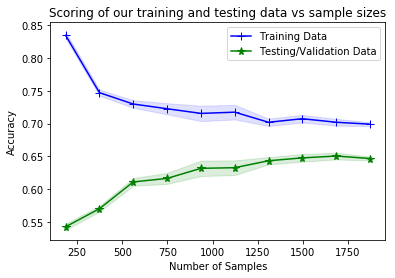

Confusion matrix, without normalization
[[  6  22   0  39]
 [  9  32   1  91]
 [  6  19   2  79]
 [  9  35   3 539]]


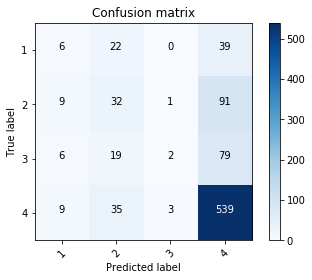

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.173950
inside decision function


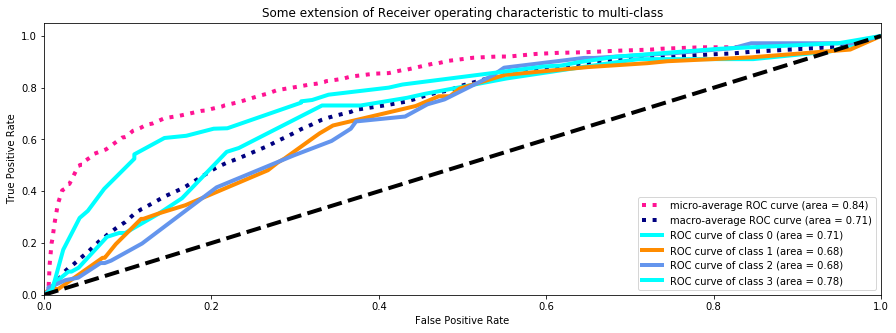

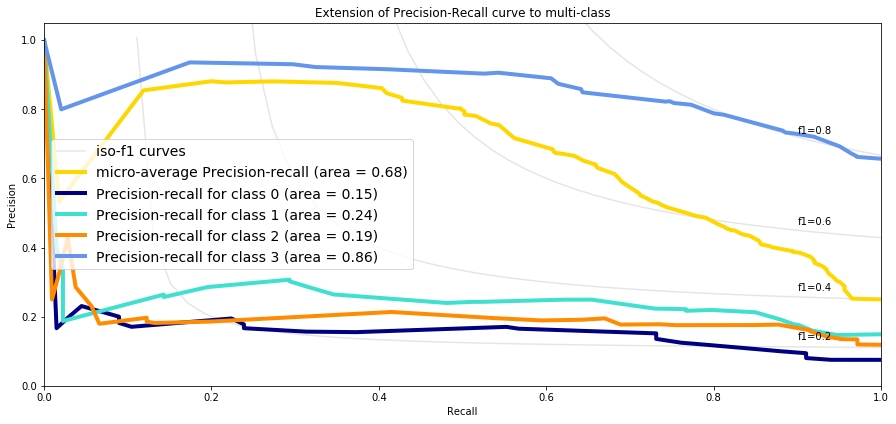

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.382078
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.573955897727087
Code block 'training' took(HH:MM:SS): 0:00:00.815771
Code block 'testing' took(HH:MM:SS): 0:00:00.005497
F1 score 0.5797189311582696
Classification report  
               precision    recall  f1-score   support

           1       0.22      0.21      0.21        67
           2       0.23      0.16      0.19       133
           3       0.17      0.10      0.13       106
           4       0.74      0.85      0.79       586

   micro avg       0.61      0.61      0.61       892
   macro avg       0.34      0.33      0.33       892
weighted avg       0.56      0.61      0.58       892



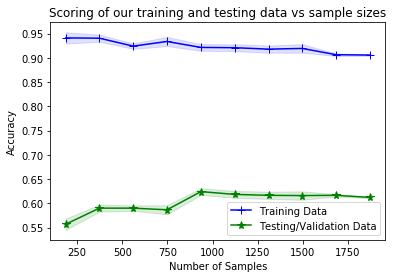

Confusion matrix, without normalization
[[ 14  14   8  31]
 [ 16  21  20  76]
 [ 18  11  11  66]
 [ 16  46  26 498]]


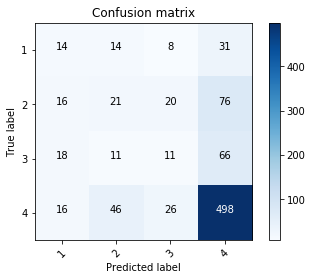

Code block 'learning_curve' took(HH:MM:SS): 0:00:04.152234
inside decision function


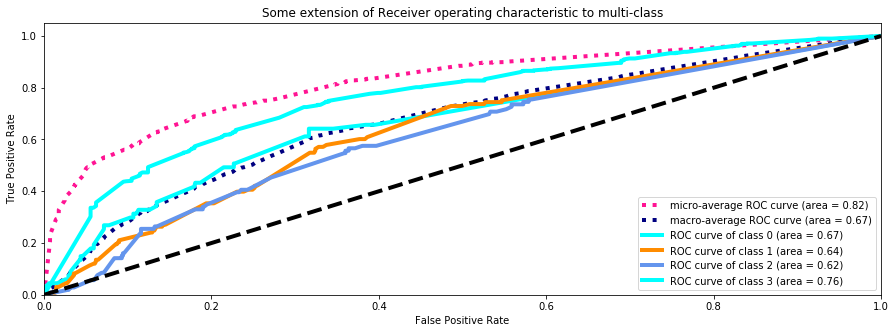

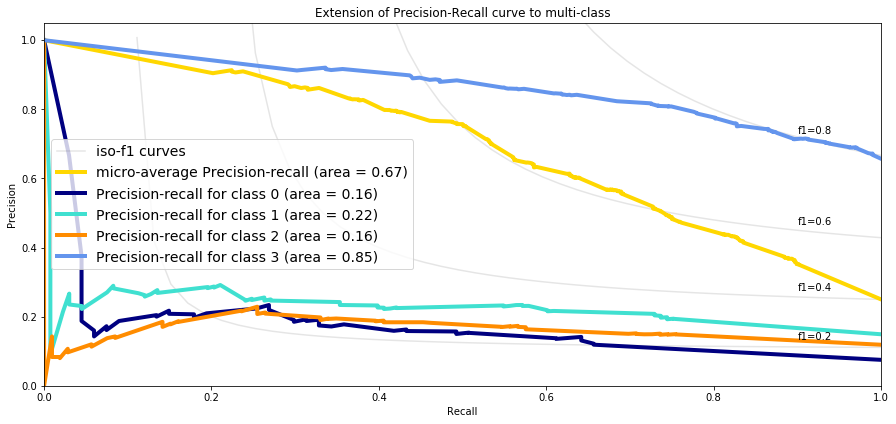

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.384238
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.5926524297223883
Code block 'training' took(HH:MM:SS): 0:00:00.846699
Code block 'testing' took(HH:MM:SS): 0:00:00.013748
F1 score 0.5791307757497581
Classification report  
               precision    recall  f1-score   support

           1       0.23      0.10      0.14        67
           2       0.24      0.17      0.20       133
           3       0.21      0.05      0.08       106
           4       0.72      0.92      0.81       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.35      0.31      0.31       892
weighted avg       0.55      0.64      0.58       892



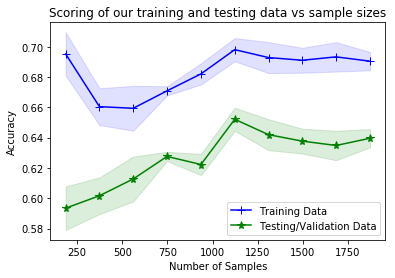

Confusion matrix, without normalization
[[  7  20   3  37]
 [ 11  22   5  95]
 [  8  17   5  76]
 [  5  33  11 537]]


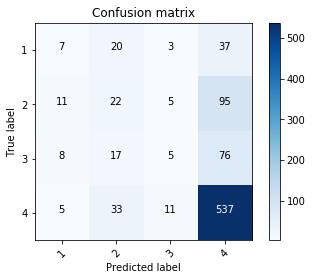

Code block 'learning_curve' took(HH:MM:SS): 0:00:03.512326
inside decision function


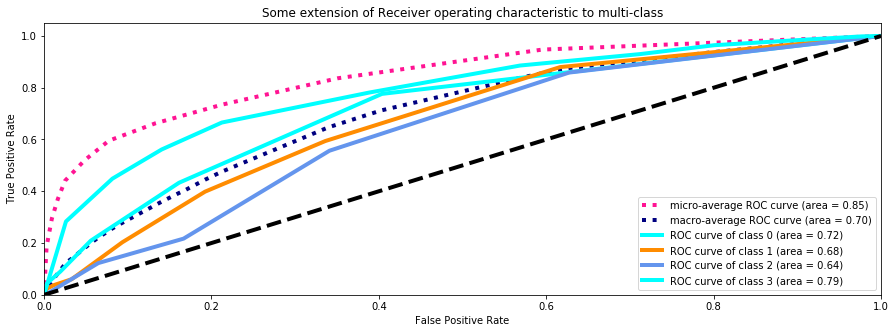

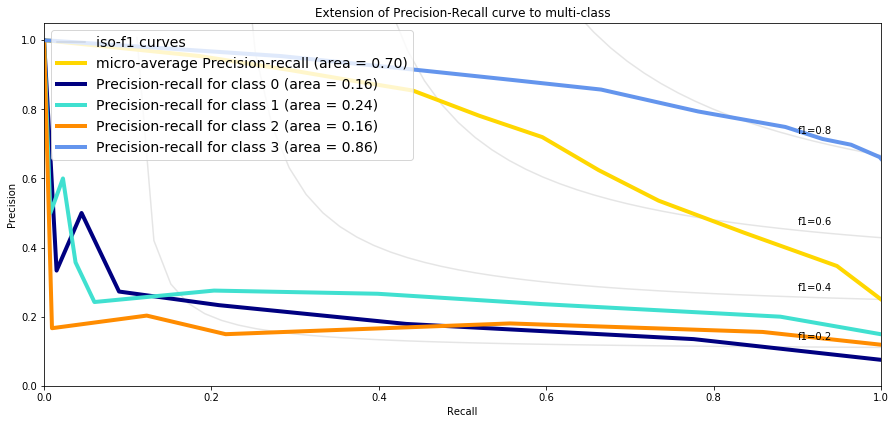

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.419801
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.5561869070999552
Code block 'training' took(HH:MM:SS): 0:00:01.443062
Code block 'testing' took(HH:MM:SS): 0:00:00.003147
F1 score 0.5663234362926793
Classification report  
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        67
           2       0.36      0.17      0.23       133
           3       0.00      0.00      0.00       106
           4       0.69      0.98      0.81       586

   micro avg       0.67      0.67      0.67       892
   macro avg       0.26      0.29      0.26       892
weighted avg       0.51      0.67      0.57       892



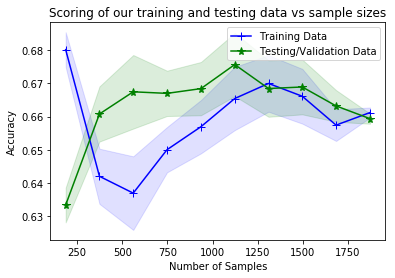

Confusion matrix, without normalization
[[  0  13   0  54]
 [  0  23   0 110]
 [  0  14   0  92]
 [  0  14   0 572]]


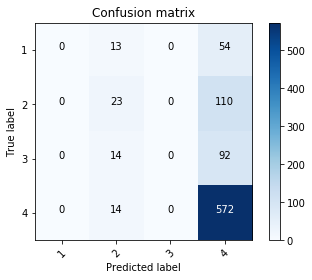

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.304248
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000018
Grid Search Best parameters  {'svc__C': 1.2, 'svc__max_iter': 200}
Grid Search Best score  0.04827211490554011
Code block 'training' took(HH:MM:SS): 0:00:07.662553
Code block 'testing' took(HH:MM:SS): 0:00:00.023966
F1 score 0.07441211238378381
Classification report  
               precision    recall  f1-score   support

           1       0.07      0.42      0.12        67
           2       0.24      0.29      0.26       133
           3       0.14      0.47      0.22       106
           4       0.00      0.00      0.00       586

   micro avg       0.13      0.13      0.13       892
   macro avg       0.11      0.29      0.15       892
weighted avg       0.06      0.13      0.07       892



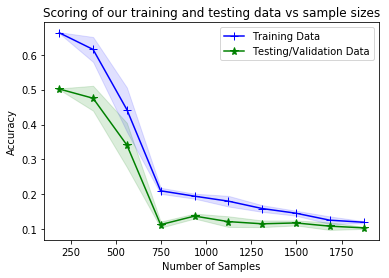

Confusion matrix, without normalization
[[ 28  19  20   0]
 [ 56  38  39   0]
 [ 30  26  50   0]
 [268  73 245   0]]


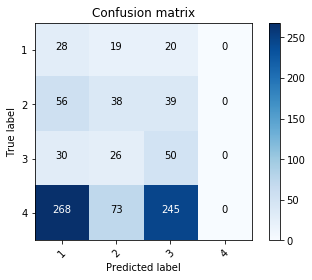

Code block 'learning_curve' took(HH:MM:SS): 0:00:16.697496
inside decision function


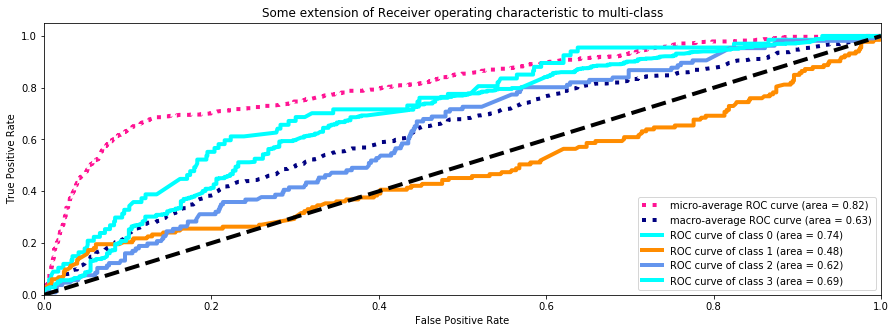

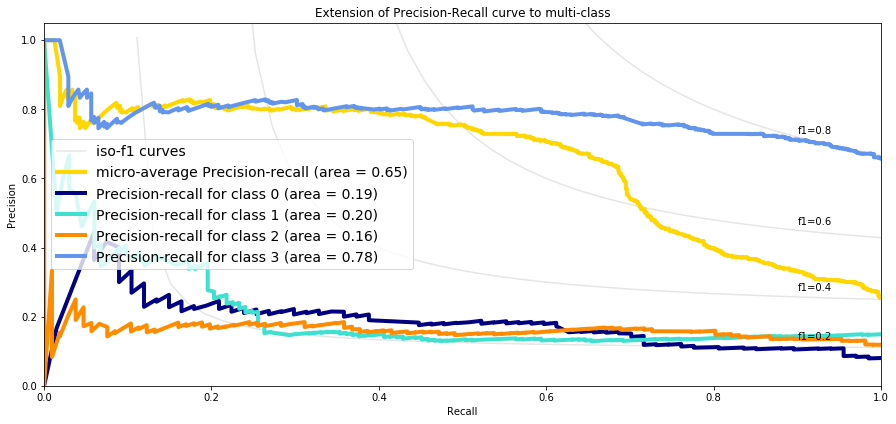

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.464056
Code block 'overalltime' took(HH:MM:SS): 0:00:50.352246
50352.24622869441


In [14]:
response = execute(_x_train,
        _y_train,
        _x_test,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [18]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
ridge,0.566323,0.260639,0.66704,2304.25,0,0,3.14709,1443.06
logisticregression,0.574702,0.274793,0.661435,3135.35,0.752782,0.868444,3.38659,768.663
decisiontreeclassifier,0.584011,0.30827,0.649103,2173.95,0.711741,0.83563,3.16188,1003.45
perceptron,0.531712,0.232349,0.647982,2950.98,0,0,3.99872,671.801
kneighborsclassifier,0.579131,0.305562,0.640135,3512.33,0.704254,0.846274,13.7478,846.699
randomforestclassifier,0.579719,0.330356,0.609865,4152.23,0.672063,0.821588,5.49717,815.771
svc,0.0744121,0.151272,0.130045,16697.5,0.632472,0.816189,23.9656,7662.55


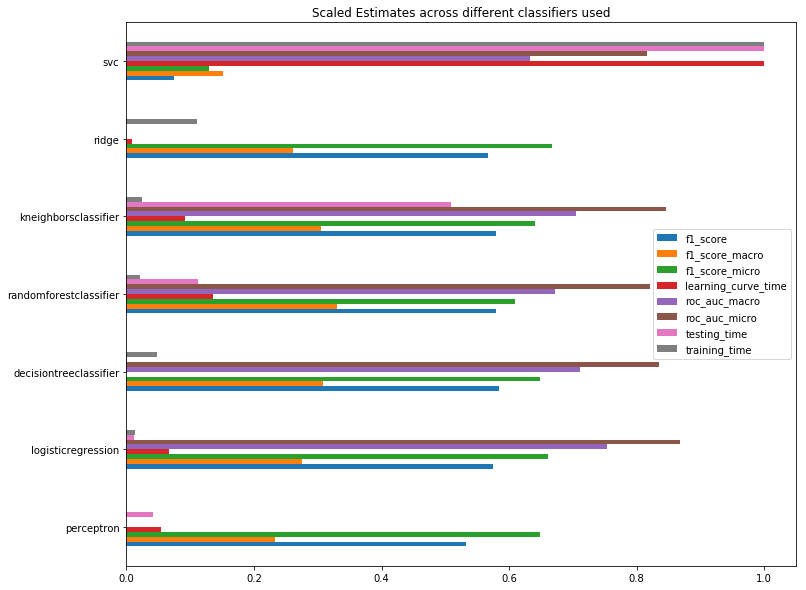

In [19]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

#### Conclusion on feature selection: selecting top 10% of features based on anova scores, leads to worse scores.

<br><br><br>

Lets increase percentage count from 10% to 25 % and see if there is any change

In [21]:

def execute( _x_train,
             _y_train,
             _x_test,
             _y_test, 
            classifiers, 
            classifier_names, 
            classifier_param_grid,
            cv  = 10 , 
            score = 'accuracy',
            scaler = StandardScaler()
           ):
    
    '''
    This method will run your data sets against the model specified 
    Models will be fed through a pipeline where the first step would be to
    execute a scaling operation.
    
    Method will also call additional lower level methods in order to plot
    precision curve, roc curve, learning curve and will also prepare a confusion matrix
    
    :returns: dict containing execution metrics such as time taken, accuracy scores
    :returntype: dict
    
    '''

    timer = CodeTimer(name='overalltime')
    model_metrics = {}

    with timer:
        for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

            pipeline = Pipeline([
                    ('scaler', scaler),
                    ('feature_select', SelectKBest(f_classif,25)),
                    (model_name, model)
            ])

            result = runGridSearchAndPredict(pipeline, 
                                             _x_train,
                                             _y_train,
                                             _x_test,
                                             _y_test, 
                                             model_param_grid ,
                                             cv = cv,
                                             score = 'f1_weighted')

            _y_prediction = result['_y_prediction']

#             cf = panda.crosstab(
#                 panda.Series(_y_test, name='Actual'),
#                 panda.Series(_y_prediction, name = 'Prediction'),
#                 margins = True
#             )

#             print(cf)

            model_metrics[model_name] = {}
            model_metrics[model_name]['confusion_matrix'] = result.get('confusion_matrix')
            model_metrics[model_name]['training_time'] = result.get('training_time')
            model_metrics[model_name]['testing_time'] = result.get('testing_time')
            model_metrics[model_name]['learning_curve_time'] = result.get('learning_curve_time')
            model_metrics[model_name]['f1_score'] = result.get('f1_score')
            model_metrics[model_name]['f1_score_macro'] = result.get('f1_score_macro')
            model_metrics[model_name]['f1_score_micro'] = result.get('f1_score_micro')
            model_metrics[model_name]['roc_auc_macro'] = result.get('roc_auc_macro')
            model_metrics[model_name]['roc_auc_micro'] = result.get('roc_auc_micro')

            model_metrics[model_name]['best_estimator'] = result.get('best_estimator')
#             model_metrics[model_name]['cf'] = cf


    print(timer.took)
    
    return model_metrics


Grid Search Best parameters  {'perceptron__eta0': 0.1, 'perceptron__max_iter': 5}
Grid Search Best score  0.579830571450417
Code block 'training' took(HH:MM:SS): 0:00:00.659240
Code block 'testing' took(HH:MM:SS): 0:00:00.003791
F1 score 0.6149638685795852
Classification report  
               precision    recall  f1-score   support

           1       0.03      0.01      0.02        67
           2       0.31      0.40      0.35       133
           3       0.33      0.19      0.24       106
           4       0.78      0.84      0.81       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.36      0.36      0.35       892
weighted avg       0.60      0.64      0.61       892



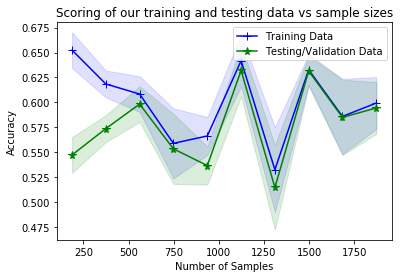

Confusion matrix, without normalization
[[  1  38   8  20]
 [  7  53  13  60]
 [  4  26  20  56]
 [ 18  56  19 493]]


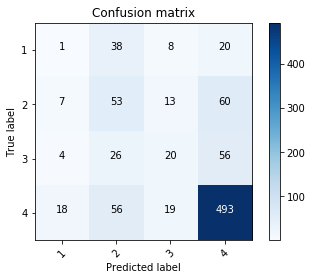

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.489516
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000014
Grid Search Best parameters  {'logisticregression__C': 100}
Grid Search Best score  0.6093544569141341
Code block 'training' took(HH:MM:SS): 0:00:01.358818
Code block 'testing' took(HH:MM:SS): 0:00:00.002967
F1 score 0.595634493587375
Classification report  
               precision    recall  f1-score   support

           1       0.36      0.07      0.12        67
           2       0.31      0.29      0.30       133
           3       0.20      0.02      0.03       106
           4       0.73      0.93      0.82       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.40      0.33      0.32       892
weighted avg       0.58      0.66      0.60       892



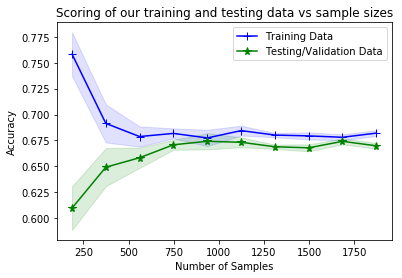

Confusion matrix, without normalization
[[  5  25   0  37]
 [  6  38   6  83]
 [  1  23   2  80]
 [  2  37   2 545]]


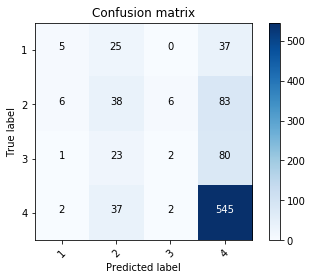

Code block 'learning_curve' took(HH:MM:SS): 0:00:05.191116
inside decision function


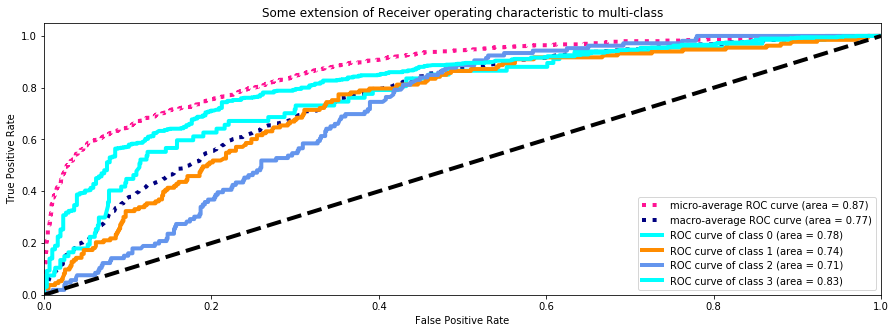

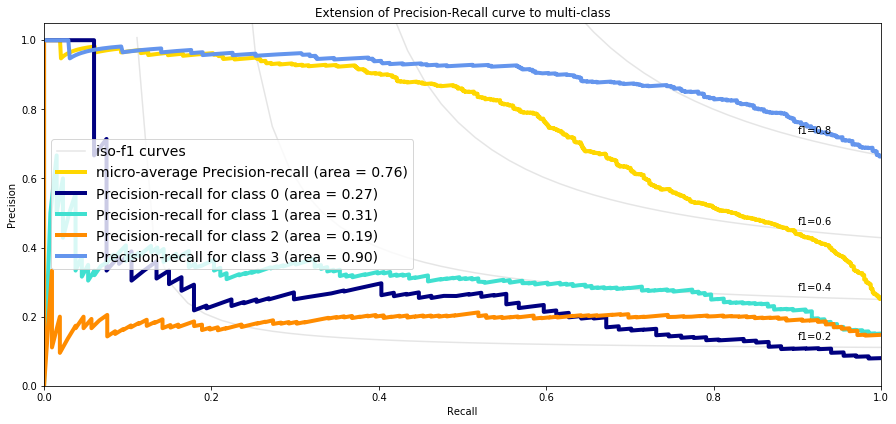

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.429537
Grid Search Best parameters  {'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 8}
Grid Search Best score  0.5870279361505832
Code block 'training' took(HH:MM:SS): 0:00:01.107341
Code block 'testing' took(HH:MM:SS): 0:00:00.003091
F1 score 0.5927582528858898
Classification report  
               precision    recall  f1-score   support

           1       0.21      0.18      0.20        67
           2       0.31      0.15      0.20       133
           3       0.24      0.12      0.16       106
           4       0.73      0.89      0.80       586

   micro avg       0.64      0.64      0.64       892
   macro avg       0.37      0.34      0.34       892
weighted avg       0.57      0.64      0.59       892



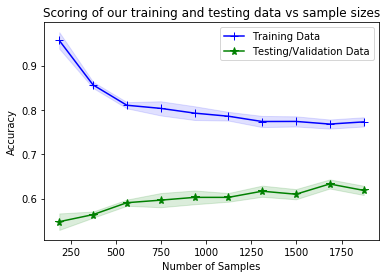

Confusion matrix, without normalization
[[ 12  11   3  41]
 [ 17  20  14  82]
 [ 12  12  13  69]
 [ 15  22  25 524]]


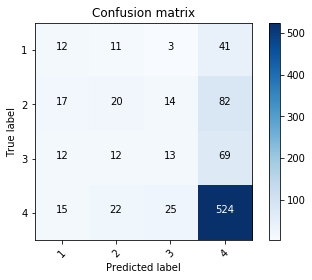

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.457954
inside decision function


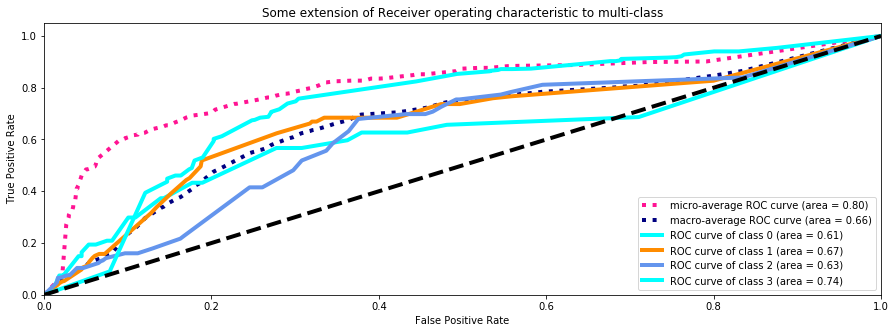

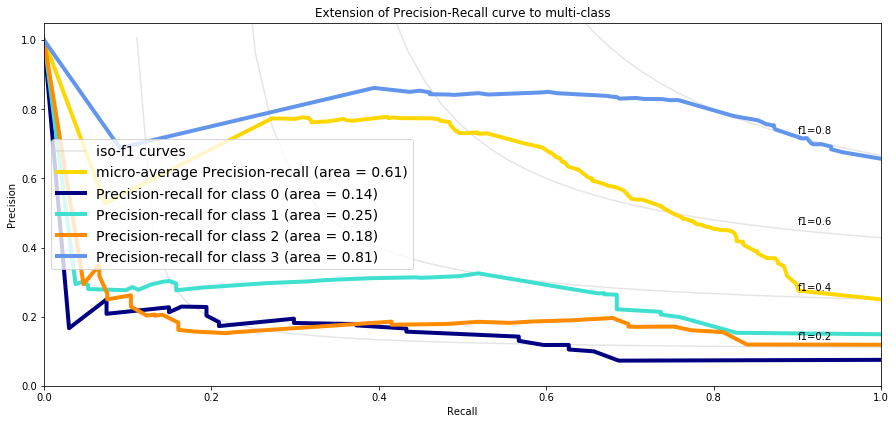

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.379813
Grid Search Best parameters  {'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__n_estimators': 12}
Grid Search Best score  0.5945962898230632
Code block 'training' took(HH:MM:SS): 0:00:00.831079
Code block 'testing' took(HH:MM:SS): 0:00:00.005718
F1 score 0.6033696505617541
Classification report  
               precision    recall  f1-score   support

           1       0.25      0.21      0.23        67
           2       0.28      0.26      0.27       133
           3       0.21      0.17      0.19       106
           4       0.77      0.82      0.80       586

   micro avg       0.62      0.62      0.62       892
   macro avg       0.38      0.37      0.37       892
weighted avg       0.59      0.62      0.60       892



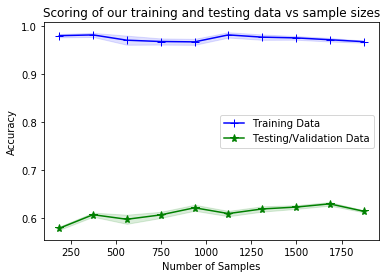

Confusion matrix, without normalization
[[ 14  20   7  26]
 [ 18  35  20  60]
 [ 12  21  18  55]
 [ 11  51  42 482]]


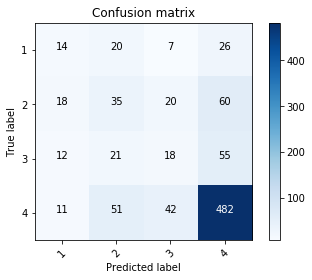

Code block 'learning_curve' took(HH:MM:SS): 0:00:04.219251
inside decision function


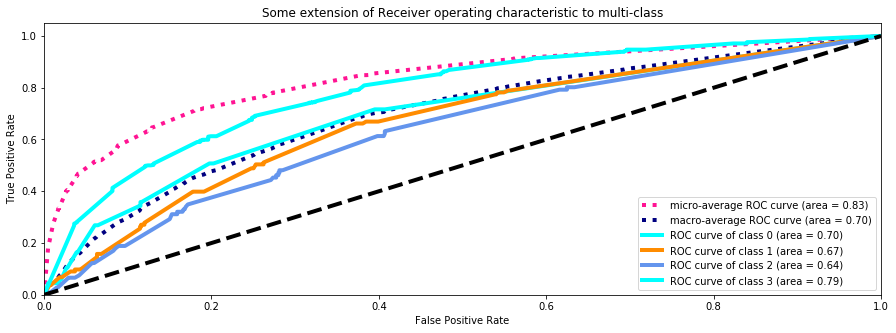

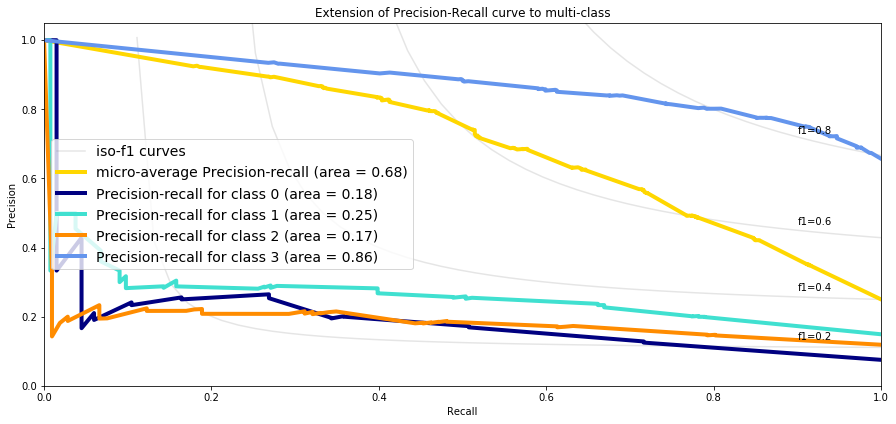

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.392880
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 10}
Grid Search Best score  0.6033921574120505
Code block 'training' took(HH:MM:SS): 0:00:01.876242
Code block 'testing' took(HH:MM:SS): 0:00:00.060539
F1 score 0.617848502759788
Classification report  
               precision    recall  f1-score   support

           1       0.34      0.21      0.26        67
           2       0.32      0.29      0.31       133
           3       0.20      0.08      0.11       106
           4       0.76      0.89      0.82       586

   micro avg       0.66      0.66      0.66       892
   macro avg       0.41      0.37      0.37       892
weighted avg       0.60      0.66      0.62       892



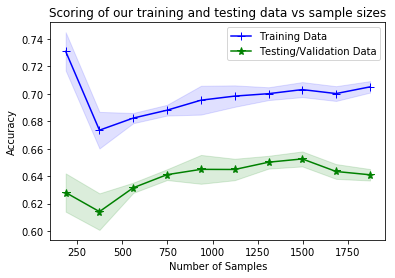

Confusion matrix, without normalization
[[ 14  19   4  30]
 [ 11  39  11  72]
 [  6  28   8  64]
 [ 10  35  17 524]]


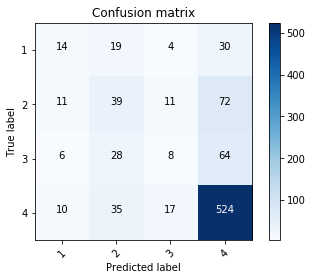

Code block 'learning_curve' took(HH:MM:SS): 0:00:07.013751
inside decision function


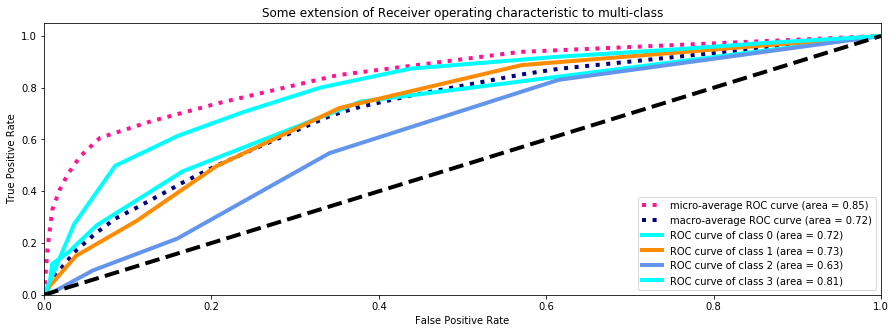

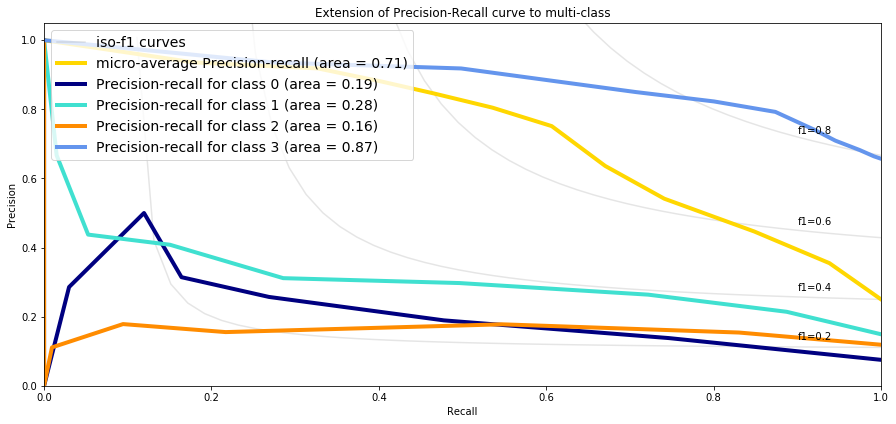

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.502791
Grid Search Best parameters  {'ridge__alpha': 1, 'ridge__max_iter': 100}
Grid Search Best score  0.5902851998511147
Code block 'training' took(HH:MM:SS): 0:00:01.445100
Code block 'testing' took(HH:MM:SS): 0:00:00.002884
F1 score 0.5906628849394622
Classification report  
               precision    recall  f1-score   support

           1       0.75      0.04      0.08        67
           2       0.37      0.29      0.32       133
           3       0.00      0.00      0.00       106
           4       0.71      0.95      0.82       586

   micro avg       0.67      0.67      0.67       892
   macro avg       0.46      0.32      0.31       892
weighted avg       0.58      0.67      0.59       892



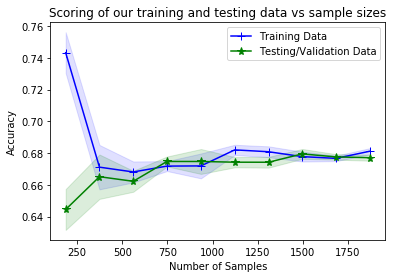

Confusion matrix, without normalization
[[  3  18   0  46]
 [  1  38   0  94]
 [  0  22   0  84]
 [  0  26   1 559]]


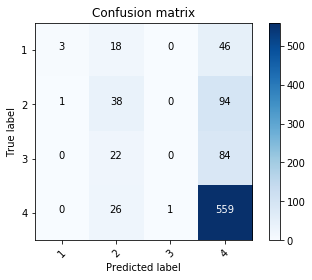

Code block 'learning_curve' took(HH:MM:SS): 0:00:02.290621
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000013
Grid Search Best parameters  {'svc__C': 1.2, 'svc__max_iter': 200}
Grid Search Best score  0.060113434520685786
Code block 'training' took(HH:MM:SS): 0:00:11.878403
Code block 'testing' took(HH:MM:SS): 0:00:00.039606
F1 score 0.042218111148594
Classification report  
               precision    recall  f1-score   support

           1       0.12      0.54      0.20        67
           2       0.02      0.01      0.01       133
           3       0.13      0.67      0.21       106
           4       0.00      0.00      0.00       586

   micro avg       0.12      0.12      0.12       892
   macro avg       0.07      0.30      0.11       892
weighted avg       0.03      0.12      0.04       892



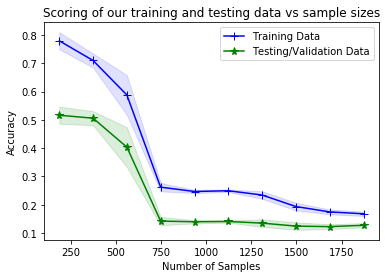

Confusion matrix, without normalization
[[ 36   3  28   0]
 [ 48   1  84   0]
 [ 31   4  71   0]
 [175  35 376   0]]


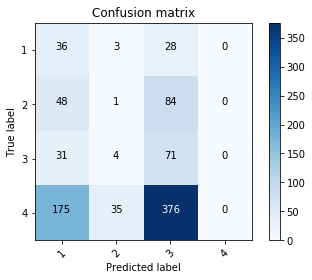

Code block 'learning_curve' took(HH:MM:SS): 0:00:26.870405
inside decision function


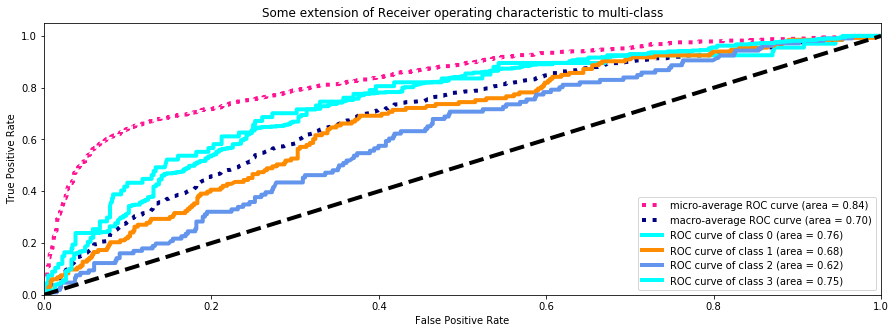

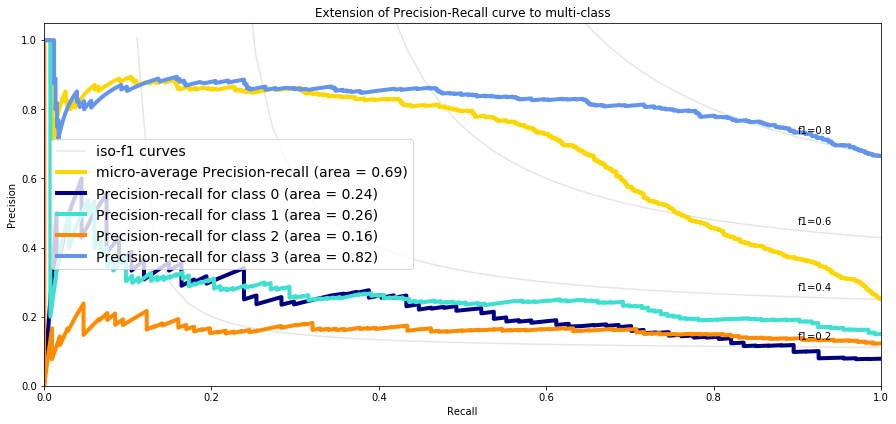

Code block 'predict_proba' took(HH:MM:SS): 0:00:00.424646
Code block 'overalltime' took(HH:MM:SS): 0:01:11.986037
71986.03719508272


In [22]:
response = execute(_x_train,
        _y_train,
        _x_test,
        _y_test,
        classifiers,
        classifier_names,
        classifier_param_grid,
        cv=cv,
        score=score,
        scaler=scaler)

In [23]:
results = panda.DataFrame(response).transpose()

# we are sorting our results using f1_score_micro, since it gives the best indicator for sorting multi class imbalanced set
results[['f1_score',
         'f1_score_macro',
         'f1_score_micro',
         'learning_curve_time',
         'roc_auc_macro',
         'roc_auc_micro',
         'testing_time',
         'training_time']]\
.sort_values(by=['f1_score_micro',],ascending=False)

,f1_score,f1_score_macro,f1_score_micro,learning_curve_time,roc_auc_macro,roc_auc_micro,testing_time,training_time
ridge,0.590663,0.305459,0.672646,2290.62,0,0,2.88427,1445.1
logisticregression,0.595634,0.318437,0.661435,5191.12,0.765356,0.874269,2.96732,1358.82
kneighborsclassifier,0.617849,0.374313,0.65583,7013.75,0.720378,0.851816,60.5389,1876.24
decisiontreeclassifier,0.592758,0.340887,0.637892,2457.95,0.662362,0.803744,3.09134,1107.34
perceptron,0.614964,0.354878,0.63565,2489.52,0,0,3.79051,659.24
randomforestclassifier,0.60337,0.370655,0.615471,4219.25,0.696858,0.833038,5.71847,831.079
svc,0.0422181,0.106645,0.121076,26870.4,0.700811,0.84011,39.606,11878.4


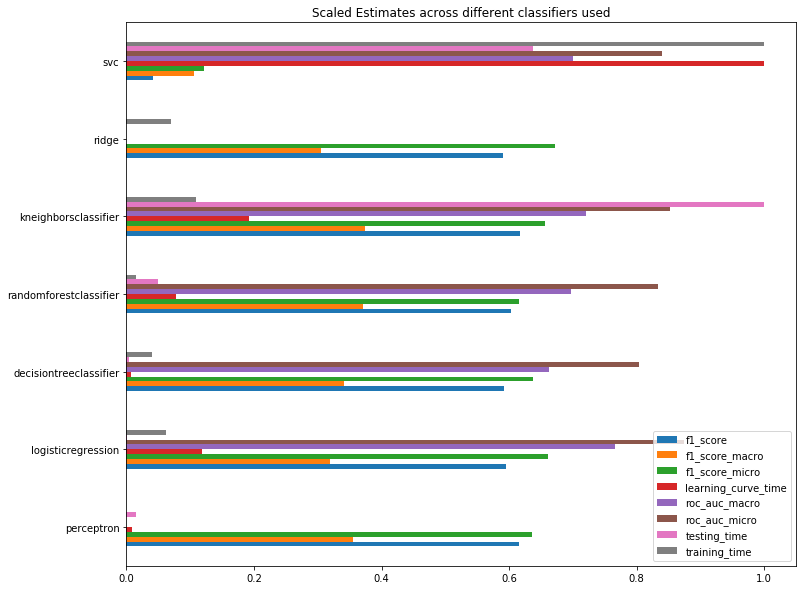

In [24]:
results['learning_curve_time'] = results['learning_curve_time'].astype('float64')
results['testing_time'] = results['testing_time'].astype('float64')
results['training_time'] = results['training_time'].astype('float64')
results['f1_score'] = results['f1_score'].astype('float64')
results['f1_score_micro'] = results['f1_score_micro'].astype('float64')
results['f1_score_macro'] = results['f1_score_macro'].astype('float64')
results['roc_auc_micro'] = results['roc_auc_micro'].astype('float64')
results['roc_auc_macro'] = results['roc_auc_macro'].astype('float64')

#scaling time parameters between 0 and 1
results['learning_curve_time'] = (results['learning_curve_time']- results['learning_curve_time'].min())/(results['learning_curve_time'].max()- results['learning_curve_time'].min())
results['testing_time'] = (results['testing_time']- results['testing_time'].min())/(results['testing_time'].max()- results['testing_time'].min())
results['training_time'] = (results['training_time']- results['training_time'].min())/(results['training_time'].max()- results['training_time'].min())

results.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()